In [6]:
import warnings
import numpy as np
import pandas as pd
import random
import os
import torch
import json
import python_avatars as pa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from torchmetrics.clustering import DunnIndex

from json_repair import repair_json
import chardet
import csv

warnings.filterwarnings("ignore")

from langchain import PromptTemplate
from langchain.output_parsers import StructuredOutputParser
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("API_KEY")

if not API_KEY:
    raise ValueError("Missing OPENAI_API_KEY in .env file")

genai.configure(api_key=os.environ["API_KEY"])
model = genai.GenerativeModel('gemini-1.5-flash',
                              generation_config={"response_mime_type": "application/json"})


In [5]:
pip install yellowbrick json_repair chardet


  Using cached json_repair-0.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
Using cached json_repair-0.25.1-py3-none-any.whl (12 kB)
Using cached chardet-5.2.0-py3-none-any.whl (199 kB)


In [3]:
pip install -U scikit-fuzzy python_avatars torch torchvision torchaudio torchmetrics


  Using cached scikit_fuzzy-0.4.2-py3-none-any.whl
  Using cached torchvision-0.18.1-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.3.1-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
Using cached torchvision-0.18.1-cp311-cp311-win_amd64.whl (1.2 MB)
Using cached torchaudio-2.3.1-cp311-cp311-win_amd64.whl (2.4 MB)
Using cached torchmetrics-1.4.0.post0-py3-none-any.whl (868 kB)
Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)


In [8]:
def clean_data(dframe):
    """
    Cleans the DataFrame by handling missing values, dropping columns with constant values,
    and label encoding categorical columns.

    Parameters:
    - dframe: Original DataFrame
    - is_labeled: Boolean indicating whether the DataFrame is labeled or unlabeled

    Returns:
    - Cleaned DataFrame
    """
    df = dframe.copy()

    # Fill missing values with mean for numeric columns
    for column in df.columns:
        if df[column].dtype != object:
            df[column] = df[column].fillna(df[column].mean())

    # Drop columns with constant values
    columns_to_drop = [col for col in df.columns if len(df[col].unique()) == 1]
    df.drop(columns=columns_to_drop, inplace=True)

    # Drop the first column - ID
    df.drop(df.columns[0], axis=1, inplace=True)

    # Label encode text label columns
    for column_name in df.columns:
        if df[column_name].dtype == object:
            df[column_name] = LabelEncoder().fit_transform(df[column_name])

    return df

def normalize_columns(dframe):
    """
    Normalizes specified columns using StandardScaler.

    Parameters:
    - df: Original DataFrame
    - list_of_columns: List of columns to normalize

    Returns:
    - DataFrame with normalized columns
    """
    df = dframe.copy()
    scaler = StandardScaler()
    df = scaler.fit_transform(df)

    return df

In [9]:
def cluster_kmeans_gpu(original_data, df, gpu_indx=0, k_values=5):
    """
    Perform K-Means clustering on the given DataFrame for a range of K values.
    Output optimal K values based on GridSearchCV.

    Parameters:
    - original_data: Original DataFrame to add clustering labels to.
    - df: DataFrame for clustering.
    - gpu_indx: Index of the GPU to use (default is 0).

    Returns:
    - None
    """
    k_values = range(2, k_values)
    device = torch.device(f'cuda:{gpu_indx}' if torch.cuda.is_available() else 'cpu')
    torch.tensor(df.values, dtype=torch.float32).to(device)

    # Hyperparameter tuning using GridSearchCV
    kmeans = KMeans()
    param_grid = {
        'n_clusters': [2, 3, 4, 5],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300, 500],
        'random_state': [0, 50]
    }
    grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV using CPU
    grid_search.fit(X=df.values[:, :-1], y=df.values[:, -1])
    best_params = grid_search.best_params_

    # Fit K-Means clustering with the optimal hyperparameters
    kmeans = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], 
                    max_iter=best_params['max_iter'], random_state=best_params['random_state'])
    kmeans.fit(df.values)  # Use CPU for fitting

    clustered_df = df.copy()
    cluster_prediction = kmeans.predict(df.values)
    clustered_df["label"] = cluster_prediction
    original_data["label"] = cluster_prediction

    label_mapping = {i: chr(65 + i) for i in range(kmeans.n_clusters)}
    clustered_df['label'] = clustered_df['label'].replace(label_mapping)
    original_data['label'] = original_data['label'].replace(label_mapping)
    clustered_df.to_csv('../data/labeled_result_kmeans.csv', index=False)
    original_data.to_csv('../data/original_data_kmeans.csv', index=False)
    
    silhouette_scores, dbi_scores, ch_indices, wcss, dunn_indices = [], [], [], [], []

    for k in k_values:
        # Fit K-Means clustering with the current K value
        kmeans = KMeans(n_clusters=k, init=best_params['init'], max_iter=best_params['max_iter'], random_state=best_params['random_state'])
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)

        # Evaluate clustering metrics
        silhouette_scores.append(silhouette_score(df, kmeans.labels_))
        dbi_scores.append(davies_bouldin_score(df, kmeans.labels_))
        ch_indices.append(calinski_harabasz_score(df, kmeans.labels_))

        # Visualize cluster assignments for optimal K
        if k == best_params['n_clusters']:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=kmeans.labels_, palette='viridis')
            plt.title(f'K-Means Clustering - {k} Clusters')
            plt.show()
            print("\n\n")

    # Visualize the Elbow Method
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
    plt.show()
    print("\n")

    # Find the K with the highest Dunn Index
    for k in k_values:
        kmeans = KMeans(n_clusters=k, init=best_params['init'], max_iter=best_params['max_iter'], random_state=best_params['random_state'])
        kmeans.fit(df.astype(np.float32))

        # Calculate the pairwise distances between data points
        distances = pairwise_distances(df.astype(np.float32))

        # Calculate the minimum inter-cluster distance
        min_inter_cluster_distance = np.inf
        for i in range(k):
            for j in range(i + 1, k):
                inter_cluster_distance = np.min(distances[np.where(kmeans.labels_ == i)][:, np.where(kmeans.labels_ == j)])
                min_inter_cluster_distance = min(min_inter_cluster_distance, inter_cluster_distance)

        # Calculate the maximum intra-cluster diameter
        max_intra_cluster_diameter = max([np.max(distances[np.where(kmeans.labels_ == i)]) for i in range(k)])

        # Calculate the Dunn Index
        dunn_index = min_inter_cluster_distance / max_intra_cluster_diameter
        dunn_indices.append(dunn_index)

    optimal_k = k_values[np.argmax(dunn_indices)]
    optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
    optimal_k_dbi = k_values[np.argmin(dbi_scores)]
    optimal_k_ch = k_values[np.argmax(ch_indices)]
    slopes = [wcss[i] - wcss[i - 1] for i in range(1, len(wcss))]
    best_k = slopes.index(max(slopes)) + 1

    print("Best K value from Elbow Method:", best_k)
    print('Optimal Value of k from Silhouette Score:', optimal_k_silhouette, 'with score:', max(silhouette_scores))
    print('Optimal Value of k from Davies Bouldin Index:', optimal_k_dbi, 'with score:', min(dbi_scores))
    print('Optimal Value of k from Calinski Harabasz Index:', optimal_k_ch, 'with score:', max(ch_indices))
    print("Dunn Index values for different K values:", dunn_indices)
    print("Optimal K based on Dunn Index:", optimal_k)
    print("\n\n")

    # Define threshold values for metrics
    threshold_silhouette = 0.5
    threshold_dbi = 1.0
    threshold_ch = 200.0
    threshold_dunn = 0.5

    # Check if each metric passes its threshold
    silhouette_passed = max(silhouette_scores) > threshold_silhouette
    dbi_passed = min(dbi_scores) < threshold_dbi
    ch_passed = max(ch_indices) > threshold_ch
    dunn_passed = max(dunn_indices) > threshold_dunn

    # Print the result for each metric and its threshold
    print(f"Silhouette Score should be greater than ({threshold_silhouette}):", silhouette_passed)
    print(f"Davies Bouldin Index should be less than ({threshold_dbi}):", dbi_passed)
    print(f"Calinski Harabasz Index should be greater than ({threshold_ch}):", ch_passed)
    print(f"Dunn Index should be greater than ({threshold_dunn}):", dunn_passed)

    # Check if all metrics passed their thresholds
    quality_check_passed = silhouette_passed and dbi_passed and ch_passed and dunn_passed

    if quality_check_passed:
        print("Clustering quality meets the thresholds.")
    else:
        print("Clustering quality does not meet the thresholds.")



In [10]:
pip install torch torchvision torchaudio torchmetrics

In [11]:
def k_means(raw_data, df_selected):
    model = KMeans(random_state=1234)
    visualizer = KElbowVisualizer(model, k=(2, 12), timings=False)
    visualizer.fit(df_selected)
    visualizer.show()
    
    optimal_clusters = visualizer.elbow_value_
    print(f"Optimal number of clusters according to the Elbow method: {optimal_clusters}")

    best_score = -np.inf
    best_clustering_metrics = {}
    best_cluster_labels = None

    metrics = {
        "Silhouette Score": [],
        "Calinski-Harabasz Index": [],
        "Davies-Bouldin Index": [],
        "Dunn Index": [],
    }

    for k in range(2, 6):
        kmeans = KMeans(
            n_clusters=k,
            n_init=20,
            init='k-means++',
            random_state=1234,
        )

        cluster_labels = kmeans.fit_predict(df_selected)
    
        sil_score = silhouette_score(df_selected, cluster_labels)
        ch_score = calinski_harabasz_score(df_selected, cluster_labels)
        db_score = davies_bouldin_score(df_selected, cluster_labels)
        dunn_index = DunnIndex(p=2)
        dunn_score = dunn_index(torch.tensor(df_selected), torch.tensor(cluster_labels))
    
        metrics["Silhouette Score"].append((k, sil_score))
        metrics["Calinski-Harabasz Index"].append((k, ch_score))
        metrics["Davies-Bouldin Index"].append((k, db_score))
        metrics["Dunn Index"].append((k, dunn_score))
        
        if sil_score > best_score:
            best_score = sil_score
            best_clustering_metrics = {
                "Silhouette Score": sil_score,
                "Calinski-Harabasz Index": ch_score,
                "Davies-Bouldin Index": db_score,
                "Dunn Index": dunn_score
            }
            best_cluster_labels = cluster_labels

    normalized_metrics = {
        "Silhouette Score": np.array([x[1] for x in metrics["Silhouette Score"]]),
        "Calinski-Harabasz Index": np.array([x[1] for x in metrics["Calinski-Harabasz Index"]]),
        "Davies-Bouldin Index": np.array([x[1] for x in metrics["Davies-Bouldin Index"]]),
        "Dunn Index": np.array([x[1] for x in metrics["Dunn Index"]]),
    }

    for key in normalized_metrics:
        normalized_metrics[key] = (normalized_metrics[key] - np.min(normalized_metrics[key])) / (np.max(normalized_metrics[key]) - np.min(normalized_metrics[key]))

    combined_scores = (
        normalized_metrics["Silhouette Score"] +
        normalized_metrics["Calinski-Harabasz Index"] +
        (1 - normalized_metrics["Davies-Bouldin Index"]) + 
        normalized_metrics["Dunn Index"]
    )

    best_combination_index = np.argmax(combined_scores)
    best_combination_params = list(range(2, 6))[best_combination_index]

    best_clustering_metrics = {
        "Silhouette Score": metrics["Silhouette Score"][best_combination_index][1],
        "Calinski-Harabasz Index": metrics["Calinski-Harabasz Index"][best_combination_index][1],
        "Davies-Bouldin Index": metrics["Davies-Bouldin Index"][best_combination_index][1],
        "Dunn Index": metrics["Dunn Index"][best_combination_index][1],
    }

    print(f"Best parameters: {best_combination_params}")
    for metric, value in best_clustering_metrics.items():
        print(f"{metric}: {value}")

    threshold_silhouette = 0.5
    threshold_dbi = 1.0
    threshold_ch = 200.0
    dunn_index_threshold = 0.5

    quality_check_passed = all([
        best_clustering_metrics["Silhouette Score"] > threshold_silhouette,
        best_clustering_metrics["Davies-Bouldin Index"] < threshold_dbi,
        best_clustering_metrics["Calinski-Harabasz Index"] > threshold_ch,
        best_clustering_metrics["Dunn Index"] > dunn_index_threshold
    ])

    if quality_check_passed:
        print("Clustering quality meets the thresholds.")
    else:
        print("Clustering quality does not meet the thresholds.")

    # Save the best clustering result
    raw_data['label'] = best_cluster_labels
    raw_data.to_csv('../data/labeled_data.csv', index=False)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    k_values = [x[0] for x in metrics["Silhouette Score"]]
    sil_values = [x[1] for x in metrics["Silhouette Score"]]
    plt.plot(k_values, sil_values, marker='o')
    plt.title("Silhouette Score vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")

    plt.subplot(2, 2, 2)
    ch_values = [x[1] for x in metrics["Calinski-Harabasz Index"]]
    plt.plot(k_values, ch_values, marker='o')
    plt.title("Calinski-Harabasz Index vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")

    plt.subplot(2, 2, 3)
    db_values = [x[1] for x in metrics["Davies-Bouldin Index"]]
    plt.plot(k_values, db_values, marker='o')
    plt.title("Davies-Bouldin Index vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Index")

    plt.subplot(2, 2, 4)
    dunn_values = [x[1] for x in metrics["Dunn Index"]]
    plt.plot(k_values, dunn_values, marker='o')
    plt.title("Dunn Index vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Dunn Index")

    plt.tight_layout()
    plt.show()

In [12]:
def process_and_visualize_labeled_data(file_path, colors):
    """
    Process and visualize labeled data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file containing labeled data.
    - colors: List of colors for the plot.

    Returns:
    - df_res: DataFrame with group sizes.
    - df_plot: DataFrame sorted by label.
    - Plots saved in the './assets/' folder.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Calculate group sizes
    df_res = round(df['label'].value_counts(normalize=True), 2).rename_axis('group').to_frame('group_size').sort_index()

    # Sort the data by labels
    df_plot = df.sort_values(by='label').reset_index(drop=True)

    # Create a directory for saving plots if it doesn't exist
    save_dir = '../frontend/public/assets/visualizations/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot 1: Group size distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df_plot["label"], palette=colors)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel('Number of Customers in the Group', fontsize=12)
    plt.title('Customer Group Distribution')
    plt.savefig(save_dir + 'group_count_plot.png')
    plt.close()

    # Plot 2: Boxplot for each numeric variable by group
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y=col, data=df, palette=colors)
        plt.xlabel('Group', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.title(f'{col} Distribution by Group')
        plt.savefig(save_dir + f'{col}_boxplot.png')
        plt.close()

    # Plot 3: Violin plot for each numeric variable by group
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='label', y=col, data=df, palette=colors)
        plt.xlabel('Group', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.title(f'{col} Distribution by Group')
        plt.savefig(save_dir + f'{col}_violinplot.png')
        plt.close()

    # Plot 4: Pairplot for numeric variables colored by group
    plt.figure(figsize=(12, 10))
    sns.pairplot(df, hue='label', palette=colors)
    plt.suptitle('Pairplot of Numeric Variables by Group', y=1.02)
    plt.savefig(save_dir + 'pairplot.png')
    plt.close()

    # Plot 5: Count plot for each categorical variable by group
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='label', data=df, palette=colors)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title(f'{col} Count by Group')
        plt.legend(title='Group')
        plt.savefig(save_dir + f'{col}_countplot.png')
        plt.close()

    return df_res, df_plot


In [13]:
def analyze_summary_dynamic(df, label_column='label', output_file='../data/summary_result.csv'):
    """
    Performs statistical analysis on all columns (except the label column) grouped by clusters.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_column (str): The column name for cluster labels. Default is 'label'.
        output_file (str): Path to save the summary CSV file. Default is '../data/summary_result.csv'.

    Returns:
        pd.DataFrame: A DataFrame containing the summary results.
    """
    
    # Exclude the label column from analysis
    cols_to_analyze = df.columns[df.columns != label_column]

    # Initialize the result DataFrame with group sizes
    df_res = round(df[label_column].value_counts(normalize=True), 2).rename_axis('group').to_frame('group_size').sort_index()

    # Calculate quartiles and ranks for each column based on its type
    for col in cols_to_analyze:
        if pd.api.types.is_numeric_dtype(df[col]):
            df_res[f"{col}_q1"] = df.groupby(label_column)[col].quantile(0.25).to_list()
            df_res[f"{col}_q3"] = df.groupby(label_column)[col].quantile(0.75).to_list()
            df_res[f"{col}_rank_q1"] = df_res[f"{col}_q1"].rank(method='max', ascending=False).astype(int).to_list()
            df_res[f"{col}_rank_q3"] = df_res[f"{col}_q3"].rank(method='max', ascending=False).astype(int).to_list()
        elif pd.api.types.is_bool_dtype(df[col]):
            df_res[f"{col}_mean"] = df.groupby(label_column)[col].mean().round(2).to_list()
        elif pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            # For categorical or object types, calculate mode (most frequent value)
            df_res[f"{col}_mode"] = df.groupby(label_column)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_list()

    # Save the result to a CSV file
    df_res.to_csv(output_file)

    return df_res

In [14]:
def generate_avatar(gender):
    female_hair_type = [pa.HairType.STRAIGHT_STRAND, pa.HairType.BOB, pa.HairType.LONG_NOT_TOO_LONG,
                        pa.HairType.BRIDE, pa.HairType.CURLY_2, pa.HairType.MIA_WALLACE,
                        pa.HairType.STRAIGHT_1, pa.HairType.STRAIGHT_2]
    male_hair_type = [pa.HairType.SHAGGY, pa.HairType.SHORT_FLAT, pa.HairType.CAESAR,
                      pa.HairType.CAESAR_SIDE_PART, pa.HairType.SHORT_WAVED, pa.HairType.POMPADOUR,
                      pa.HairType.ELVIS, pa.HairType.BUZZCUT]
    clothing_color = ["#E5CB93", "#A9DBEA", "#DBD2F4", "#FF8B71", "#878ECD", "#046582",
                      "#DAD8D7", "#DAD8D7", "#C0D8C0", "#DD4A48", "#FEA82F", "#FF6701"]
    clothing_style = [pa.ClothingType.SHIRT_SCOOP_NECK, pa.ClothingType.BLAZER_SWEATER,
                      pa.ClothingType.COLLAR_SWEATER, pa.ClothingType.HOODIE,
                      pa.ClothingType.SHIRT_CREW_NECK]
    hair_color = ["#6B3307", "#000000", "#C4942D", "#B05A08", "#3F4E4F", "#A27B5C",
                  "#A19882", "#555555", "#7F7C82", "#FEA82F"]

    if gender == 'Female':
        my_avatar = pa.Avatar(
            style=pa.AvatarStyle.CIRCLE,
            background_color="#F4F9F9",
            top=random.choice(female_hair_type),
            eyebrows=pa.EyebrowType.DEFAULT_NATURAL,
            eyes=pa.EyeType.DEFAULT,
            nose=pa.NoseType.DEFAULT,
            mouth=pa.MouthType.SMILE,
            facial_hair=pa.FacialHairType.NONE,
            skin_color="#FBD9BF",
            hair_color=random.choice(hair_color),
            accessory=pa.AccessoryType.NONE,
            clothing=random.choice(clothing_style),
            clothing_color=random.choice(clothing_color)
        )
    else:
        my_avatar = pa.Avatar(
            style=pa.AvatarStyle.CIRCLE,
            background_color="#F4F9F9",
            top=random.choice(male_hair_type),
            eyebrows=pa.EyebrowType.DEFAULT_NATURAL,
            eyes=pa.EyeType.DEFAULT,
            nose=pa.NoseType.DEFAULT,
            mouth=pa.MouthType.SMILE,
            facial_hair=pa.FacialHairType.NONE,
            skin_color="#FBD9BF",
            hair_color=random.choice(hair_color),
            accessory=pa.AccessoryType.NONE,
            clothing=random.choice(clothing_style),
            clothing_color=random.choice(clothing_color)
        )

    image_svg = my_avatar.render()
    image_svg = image_svg.replace("264px", "100%")
    image_svg = image_svg.replace("280px", "100%")

    return image_svg

In [15]:
def generate_persona(summary: dict) -> dict:
    """Generates a customer persona based on input summary.

    Args:
        summary (dict): Summary dictionary containing demographic, interest, and behavior information.

    Returns:
        dict: A dictionary containing the generated customer persona.
    """

    persona_schema = {
        "name": "response",
        "description": """{
            "cluster_summaries": [],
            "cluster_personas": []
        }"""
    }

    response_schema = [persona_schema]
    output_parser = StructuredOutputParser.from_response_schemas(response_schema)
    format_instructions = output_parser.get_format_instructions()

    prompt_template = """
    Can you analyze the provided summary data and generate a JSON object containing the following information:

    1. cluster_summaries: An array containing textual summaries for each cluster group. Each summary should highlight key insights about the customer segment, including:
        - Purchase patterns (e.g., most frequently purchased items, typical quantities)
        - Price sensitivity (e.g., average unit price, ranking in quartiles)
        - Customer churn (e.g., ranking of customer IDs in quartiles)
        - Geographic location (if applicable)
        
    2. cluster_personas: An array containing detailed customer personas for each cluster group, defined by the summary information. Each persona should include:
        - Demographics (name, age, gender, marital status, family structure, income level, location, occupation)
        - Psychographics (values and beliefs, interests and hobbies, lifestyle choices)
        - Needs and pain points (needs, pain points)
        - Behavioral data (behavioral drivers, obstacles to purchasing, expectations, marketing suggestions)
        
    Example output (JSON):
    {{
        "cluster_summaries": [
            "Key insight 1 - Key insight 2",
            "Key insight 1 - Key insight 2",
            "Key insight 1 - Key insight 2"
        ],
        "cluster_personas": [
            {{
                "customer_persona": "Anna",
                "demographics": {{
                    "name": "Anna",
                    "age": "age_value",
                    "gender": "gender_value",
                    "marital_status": "marital_status_value",
                    "family_structure": "family_structure_value",
                    "income_level": "income_level_value",
                    "location": "location_value",
                    "occupation": "occupation_value"
                }},
                "psychographics": {{
                    "values_and_beliefs": "values_and_beliefs_value",
                    "interests_and_hobbies": "interests_and_hobbies_value",
                    "lifestyle_choices": "lifestyle_choices_value"
                }},
                "needs_and_pain_points": {{
                    "needs": "needs_value",
                    "pain_points": "pain_points_value"
                }},
                "behavioral_data": {{
                    "behavioral_drivers": "behavioral_drivers_value",
                    "obstacles_to_purchasing": "obstacles_to_purchasing_value",
                    "expectations": "expectations_value",
                    "marketing_suggestions": "marketing_suggestions_value"
                }}
            }}
        ]
    }}

    Summary:
    {summary}

    {format_instructions}
    """

    prompt = PromptTemplate(
        input_variables=["summary"],
        template=prompt_template,
        partial_variables={"format_instructions": format_instructions},
    )

    response = model.generate_content(prompt.format(summary=json.dumps(summary)))
    output = ""
    for chunk in response:
        output += chunk.text


    try:
        personas = json.loads(output)
    except json.JSONDecodeError as e:
        raise ValueError(f"Generated content is not valid JSON: {e}")
    
    if "response" in personas:
        for persona in personas["response"].get("cluster_personas", []):
            gender = persona.get("demographics", {}).get("gender", "string")
            avatar_url = generate_avatar(gender)
            persona["avatar"] = avatar_url
    elif "cluster_personas" in personas:
        for persona in personas["cluster_personas"]:
            gender = persona.get("demographics", {}).get("gender", "string")
            avatar_url = generate_avatar(gender)
            persona["avatar"] = avatar_url
            
    return personas

In [16]:
def generate_visualizations(col_names: dict) -> dict:
    """Generates visualizations based on col_names data."""

    visualizations_schema = {
        "name": "response",
        "description": """{
            "dashboard_title": "Customer Analysis Dashboard",
            "rows": [
                {
                    "row_type": "cards",
                    "items": [
                        {
                            "title": "string",
                            "col_name": "string",
                            "function": "sum/avg/max/min"
                        }
                    ]
                },
                {
                    "row_type": "charts",
                    "charts": [
                        {
                            "title": "string",
                            "type": "line/bar/pie/scatter",
                            "x_axis_column": "string",
                            "y_axis_column": "string"
                        },
                        {
                            "title": "string",
                            "type": "line/bar/pie/scatter",
                            "x_axis_column": "string",
                            "y_axis_column": "string"
                        },
                        {
                            "title": "string",
                            "type": "line/bar/pie/scatter",
                            "x_axis_column": "string",
                            "y_axis_column": "string"
                        },
                        {
                            "title": "string",
                            "type": "line/bar/pie/scatter",
                            "x_axis_column": "string",
                            "y_axis_column": "string"
                        }
                    ]
                }
            ]
        }"""
    }

    response_schema = [visualizations_schema]
    output_parser = StructuredOutputParser.from_response_schemas(response_schema)
    format_instructions = output_parser.get_format_instructions()

    prompt_template = """
    I have provided column names of my dataset. Generate a dashboard in the following JSON format with 3 meaningful and helpful cards and 6 charts (line, bar, pie, or scatter):
    IMPORTANT: DONOT USE HISTOGRAMS

    {{
        "dashboard_title": "Customer Analysis Dashboard",
        "rows": [
            {{
                "row_type": "cards",
                "items": [
                    {{
                        "title": "string",
                        "col_name": "string",
                        "function": "sum/avg/max/min"
                    }},
                    {{
                        "title": "string",
                        "col_name": "string",
                        "function": "sum/avg/max/min"
                    }},
                    {{
                        "title": "string",
                        "col_name": "string",
                        "function": "sum/avg/max/min"
                    }}
                ]
            }},
            {{
                "row_type": "charts",
                "charts": [
                    {{
                        "title": "string",
                        "type": "line/bar/pie/scatter",
                        "x_axis_column": "string",
                        "y_axis_column": "string"
                    }},
                    {{
                        "title": "string",
                        "type": "line/bar/pie/scatter",
                        "x_axis_column": "string",
                        "y_axis_column": "string"
                    }},
                    {{
                        "title": "string",
                        "type": "line/bar/pie/scatter",
                        "x_axis_column": "string",
                        "y_axis_column": "string"
                    }},
                    {{
                        "title": "string",
                        "type": "line/bar/pie/scatter",
                        "x_axis_column": "string",
                        "y_axis_column": "string"
                    }}
                ]
            }}
        ]
    }}

    Here is the list of my dataset colums:
    {col_names}

    {format_instructions}
    """

    prompt = PromptTemplate(
        input_variables=["summary"],
        template=prompt_template,
        partial_variables={"format_instructions": format_instructions},
    )

    response = model.generate_content(prompt.format(col_names=col_names))
    output = ""
    for chunk in response:
        output += chunk.text

    try:
        output = repair_json(output)
        visualizations = json.loads(output)
    except json.JSONDecodeError as e:
        raise ValueError(f"Generated content is not valid JSON: {e}")
        
    return visualizations

In [17]:
def calculate_dashboard_metrics(response, dataset, cluster_col='label'):
    df = pd.DataFrame(dataset)
    
    overall_metrics = {}
    cluster_metrics = {cluster: {} for cluster in df[cluster_col].unique()}
    
    for row in response.get('rows', response.get('response', {}).get('rows', [])):
        if row["row_type"] == "cards":
            for item in row["items"]:
                col_name = item["col_name"]
                func = item["function"]
                
                if func == "sum":
                    overall_value = round(df[col_name].sum(), 2)
                elif func == "avg":
                    overall_value = round(df[col_name].mean(), 2)
                elif func == "count":
                    overall_value = df[col_name].count()
                elif func == "max":
                    overall_value = round(df[col_name].max(), 2)
                elif func == "min":
                    overall_value = round(df[col_name].min(), 2)
                else:
                    overall_value = None
                
                overall_metrics[item["title"]] = overall_value
                
                for cluster, group in df.groupby(cluster_col):
                    if func == "sum":
                        cluster_value = round(group[col_name].sum(), 2)
                    elif func == "avg":
                        cluster_value = round(group[col_name].mean(), 2)
                    elif func == "count":
                        cluster_value = group[col_name].count()
                    elif func == "max":
                        cluster_value = round(group[col_name].max(), 2)
                    elif func == "min":
                        cluster_value = round(group[col_name].min(), 2)
                    else:
                        cluster_value = None
                    
                    cluster_metrics[cluster][item["title"]] = cluster_value
                
                item["value"] = overall_value
                item["cluster_values"] = {cluster: cluster_metrics[cluster][item["title"]] for cluster in cluster_metrics}
    
        elif row["row_type"] == "charts":
            for chart in row["charts"]:
                x_column = chart["x_axis_column"]
                y_column = chart["y_axis_column"]
                
                if chart["type"] == "pie":
                    if x_column and x_column in df.columns:
                        value_counts = df[x_column].value_counts().reset_index()
                        value_counts.columns = ['label', 'value']
                        chart["data"] = value_counts.to_dict(orient='records')
                
                elif chart["type"] == "line":
                    if x_column in df.columns and y_column in df.columns:
                        x_data = df[x_column].tolist()
                        y_data = df[y_column].tolist()
                        chart["series"] = [{"data": y_data, "label": y_column, "id": f"{y_column}_line"}]
                        chart["xAxis"] = [{"scaleType": "point", "data": x_data}]

                elif chart["type"] == "bar":
                    if x_column in df.columns and y_column in df.columns:
                        x_data = df[x_column].tolist()
                        y_data = df[y_column].tolist()
                        chart["series"] = [{"data": y_data, "label": y_column, "id": f"{y_column}_bar"}]
                        chart["xAxis"] = [{"data": x_data, "scaleType": "band"}]

                elif chart["type"] == "scatter":
                    if x_column in df.columns and y_column in df.columns:
                        scatter_data = [
                            {"x": df[x_column].iloc[i], "y": df[y_column].iloc[i], "id": i+1}
                            for i in range(len(df))
                        ]
                        x_min = df[x_column].min()
                        chart["series"] = [{"data": scatter_data, "label": f"{x_column} vs {y_column}", "id": f"{x_column}_{y_column}_scatter"}]
                        chart["xAxis"] = [{"min": x_min}]

    return response

In [18]:
def process_dataset(dataset, selected_features):
    cleaned_data = clean_data(dataset[selected_features])
    normalized_data = normalize_columns(cleaned_data)
    k_means(dataset, normalized_data)
    
    dt = pd.read_csv('../data/labeled_data.csv')
    analyze_summary_dynamic(dt, 'label')
    
    summary = pd.read_csv('../data/summary_result.csv')
    summary_dict = summary.to_dict(orient='records')
    # personas = generate_persona(summary_dict)
    
    # with open('../data/personas_output.json', 'w') as file:
    #     json.dump(personas, file, indent=4)

    visualizations = generate_visualizations(dt.columns.tolist())
    cards = calculate_dashboard_metrics(visualizations, dt)
    print(cards)

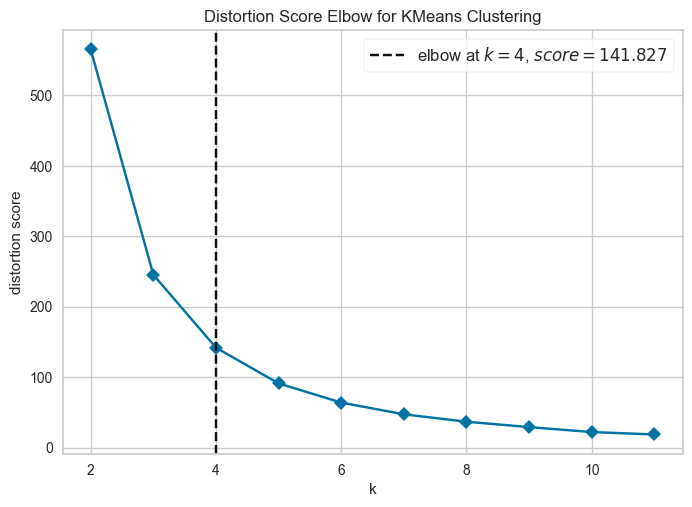

Optimal number of clusters according to the Elbow method: 4
Best parameters: 3
Silhouette Score: 0.595779367126416
Calinski-Harabasz Index: 9113.070920118666
Davies-Bouldin Index: 0.4925817595713125
Dunn Index: 1.9574173851940107
Clustering quality meets the thresholds.


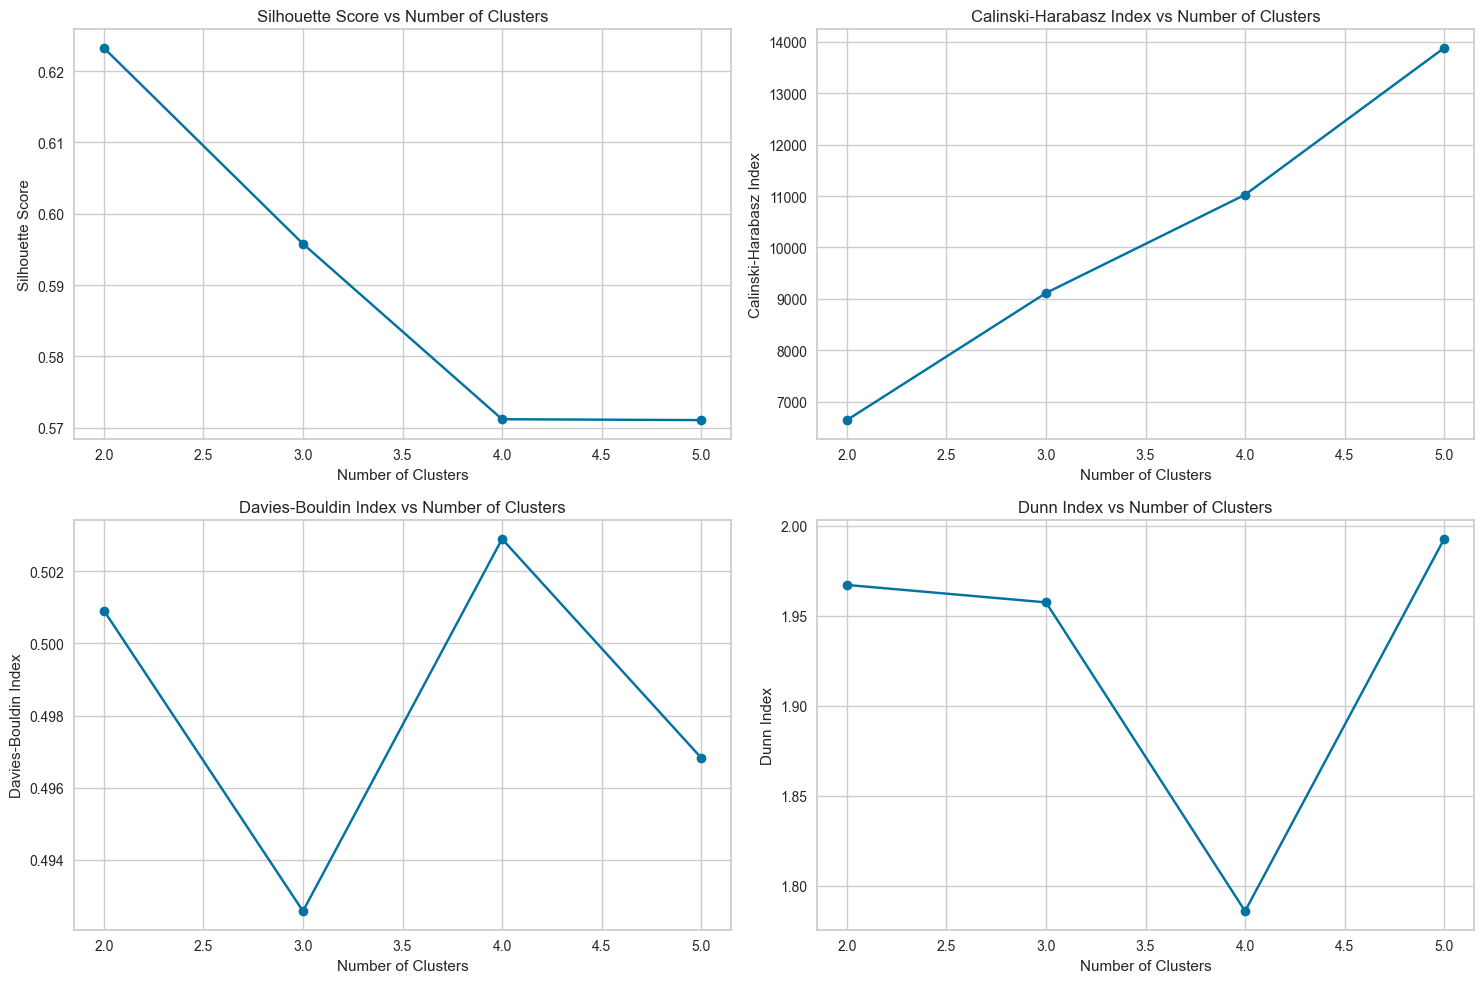

{'dashboard_title': 'Customer Analysis Dashboard', 'rows': [{'row_type': 'cards', 'items': [{'title': 'Total Revenue', 'col_name': 'Z_Revenue', 'function': 'sum', 'value': 24640, 'cluster_values': {1: 12628, 0: 12012}}, {'title': 'Average Income', 'col_name': 'Income', 'function': 'avg', 'value': 52247.25, 'cluster_values': {1: 52095.45, 0: 52405.78}}, {'title': 'Total Customers', 'col_name': 'ID', 'function': 'count', 'value': 2240, 'cluster_values': {1: 1148, 0: 1092}}]}, {'row_type': 'charts', 'charts': [{'title': 'Income Distribution', 'type': 'bar', 'x_axis_column': 'Income', 'y_axis_column': 'ID', 'series': [{'data': [5524, 2174, 4141, 6182, 5324, 7446, 965, 6177, 4855, 5899, 1994, 387, 2125, 8180, 2569, 2114, 9736, 4939, 6565, 2278, 9360, 5376, 1993, 4047, 1409, 7892, 2404, 5255, 9422, 1966, 6864, 3033, 5710, 7373, 8755, 10738, 4339, 10755, 8595, 2968, 8601, 503, 8430, 7281, 2139, 1371, 9909, 7286, 7244, 6566, 8614, 4114, 1331, 2225, 9381, 6260, 10383, 7437, 8557, 8375, 6853, 30

In [19]:
dataset = pd.read_csv('../../frontend/public/datasets/sample-dataset2.csv', sep='\t')
process_dataset(dataset, ['Income', 'Recency'])

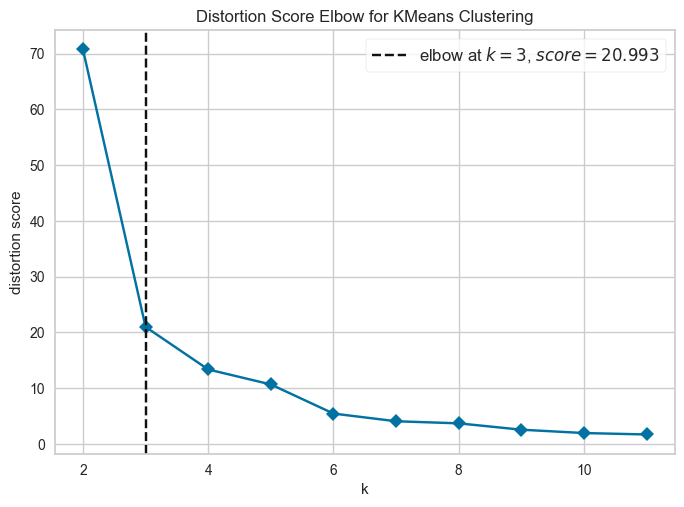

Optimal number of clusters according to the Elbow method: 3
Best parameters: 3
Silhouette Score: 0.6540040369722331
Calinski-Harabasz Index: 842.231321889001
Davies-Bouldin Index: 0.42267337650878317
Dunn Index: 1.991081573587737
Clustering quality meets the thresholds.


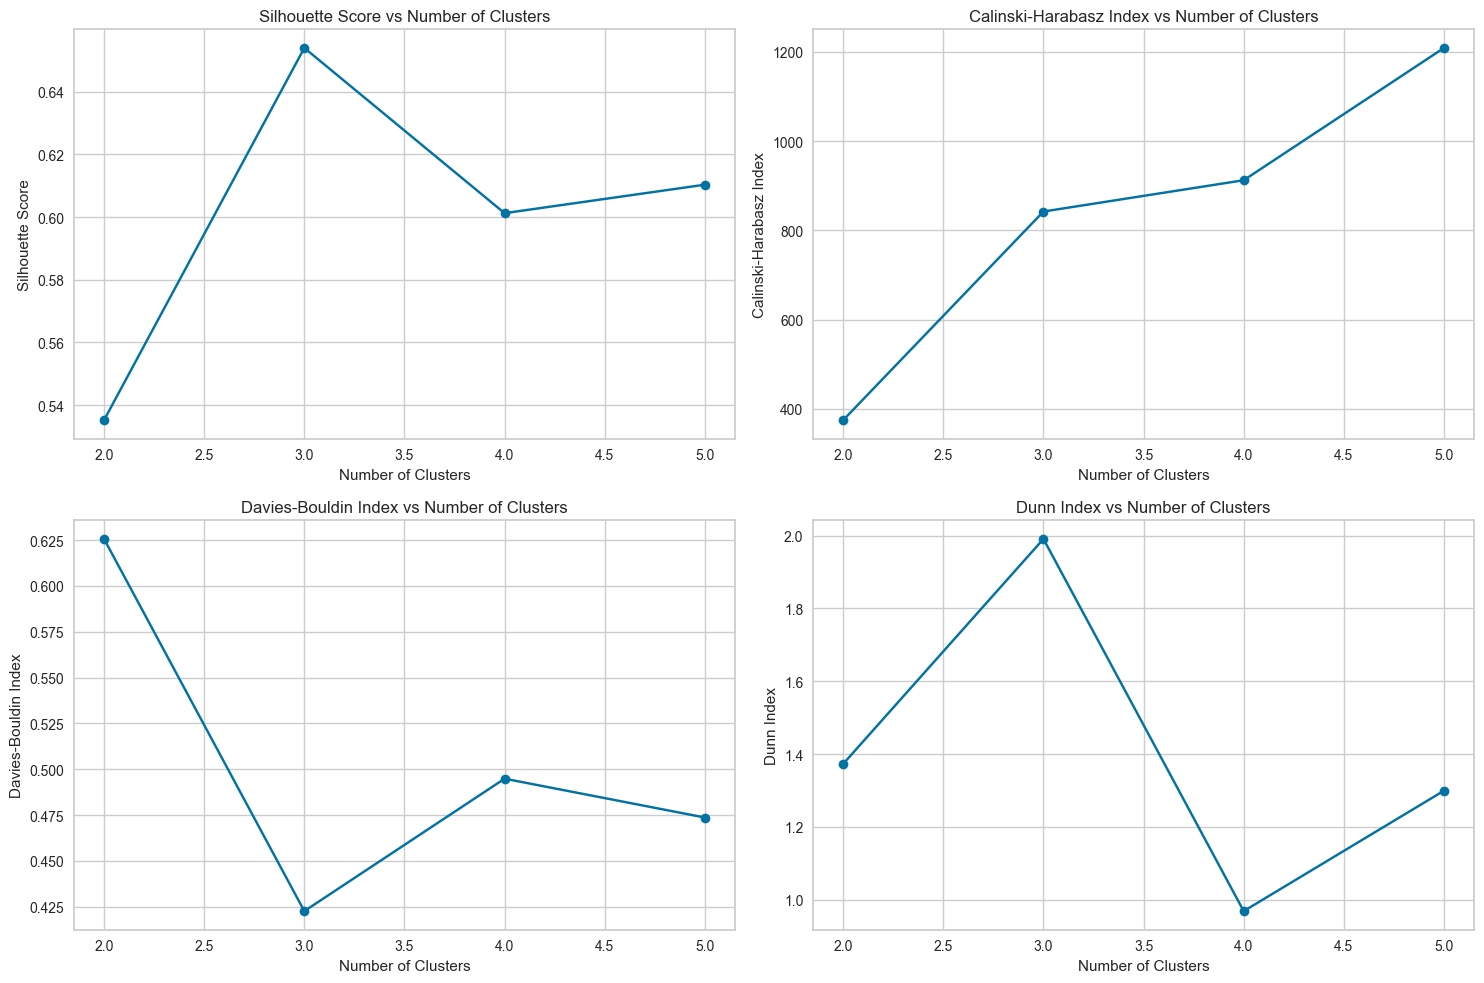

{'response': {'dashboard_title': 'Customer Analysis Dashboard', 'rows': [{'row_type': 'cards', 'items': [{'title': 'Total Customers', 'col_name': 'CustomerID', 'function': 'count', 'value': 200, 'cluster_values': {1: 95, 2: 58, 0: 47}}, {'title': 'Average Age', 'col_name': 'Age', 'function': 'avg', 'value': 38.85, 'cluster_values': {1: 42.22, 2: 30.0, 0: 42.96}}, {'title': 'Highest Spending Score', 'col_name': 'Spending Score (1-100)', 'function': 'max', 'value': 99, 'cluster_values': {1: 65, 2: 99, 0: 31}}]}, {'row_type': 'charts', 'charts': [{'title': 'Gender Distribution', 'type': 'pie', 'x_axis_column': 'Gender', 'y_axis_column': 'CustomerID', 'data': [{'label': 'Female', 'value': 112}, {'label': 'Male', 'value': 88}]}, {'title': 'Age vs. Spending Score', 'type': 'scatter', 'x_axis_column': 'Age', 'y_axis_column': 'Spending Score (1-100)', 'series': [{'data': [{'x': 19, 'y': 39, 'id': 1}, {'x': 21, 'y': 81, 'id': 2}, {'x': 20, 'y': 6, 'id': 3}, {'x': 23, 'y': 77, 'id': 4}, {'x': 31

In [20]:
dataset = pd.read_csv('../../frontend/public/datasets/sample-dataset1.csv')
process_dataset(dataset, ['Annual Income (k$)', 'Spending Score (1-100)'])

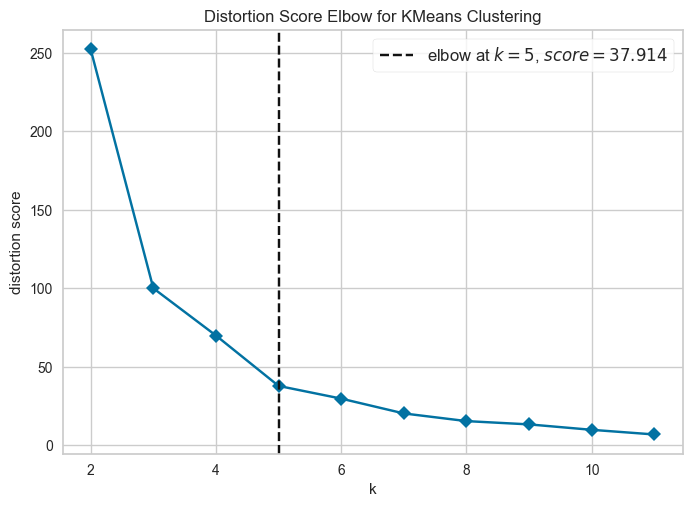

Optimal number of clusters according to the Elbow method: 5
Best parameters: 5
Silhouette Score: 0.7122953860408004
Calinski-Harabasz Index: 426.74807190080537
Davies-Bouldin Index: 0.4896346667307815
Dunn Index: 1.1010686010468538
Clustering quality meets the thresholds.


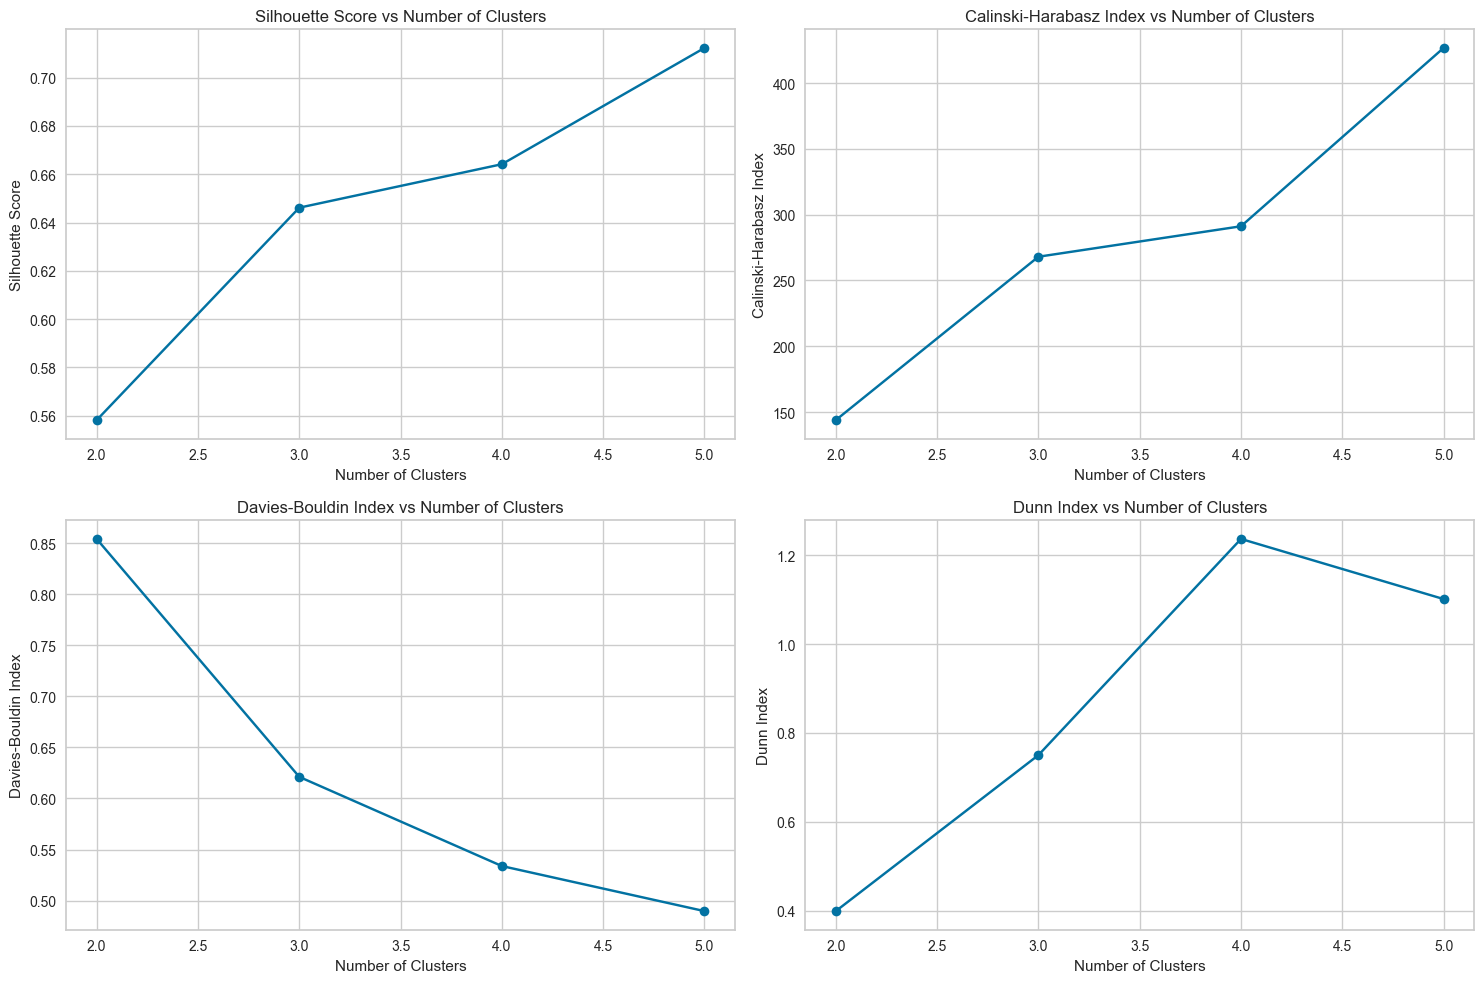

{'response': {'dashboard_title': 'Customer Analysis Dashboard', 'rows': [{'row_type': 'cards', 'items': [{'title': 'Total Orders', 'col_name': 'InvoiceNo', 'function': 'count', 'value': 192, 'cluster_values': {4: 94, 1: 56, 2: 21, 0: 6, 3: 15}}, {'title': 'Average Order Value', 'col_name': 'UnitPrice', 'function': 'avg', 'value': 2.9, 'cluster_values': {4: 1.6, 1: 2.08, 2: 7.37, 0: 15.2, 3: 2.97}}, {'title': 'Total Revenue', 'col_name': 'UnitPrice', 'function': 'sum', 'value': 557.75, 'cluster_values': {4: 150.64, 1: 116.68, 2: 154.73, 0: 91.2, 3: 44.5}}]}, {'row_type': 'charts', 'charts': [{'title': 'Orders by Country', 'type': 'bar', 'x_axis_column': 'Country', 'y_axis_column': 'InvoiceNo', 'series': [{'data': [581569, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581570, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 581571, 58157

In [21]:
dataset = pd.read_csv('../../frontend/public/datasets/data.csv', encoding='unicode_escape')
process_dataset(dataset, ['Quantity', 'UnitPrice', 'Country'])

In [23]:
def detect_encoding(file_path):
    """Detect file encoding using chardet."""
    with open(file_path, 'rb') as file:
        raw_data = file.read(10000)  # Read the first 10,000 bytes
    result = chardet.detect(raw_data)
    return result['encoding']

def detect_delimiter(file_path, encoding, n_lines=20):
    """Detect the delimiter by reading a few lines and using the csv.Sniffer."""
    with open(file_path, 'r', encoding=encoding) as file:
        sample_lines = ''.join([next(file) for _ in range(n_lines)])
    sniffer = csv.Sniffer()
    delimiter = sniffer.sniff(sample_lines).delimiter
    return delimiter

def read_csv_auto(file_path, n_lines=20):
    """Read a CSV file with automatic detection of encoding and delimiter."""
    # Detect encoding
    encoding = detect_encoding(file_path)
    print(f"Detected encoding: {encoding}")
    
    # Detect delimiter
    delimiter = detect_delimiter(file_path, encoding, n_lines)
    print(f"Detected delimiter: {delimiter}")
    
    # Read the CSV file with the detected encoding and delimiter
    df = pd.read_csv(file_path, encoding=encoding, delimiter=delimiter)
    return df

dataset = read_csv_auto('../../frontend/public/datasets/data.csv')
print(dataset.head())

Detected encoding: ascii
Detected delimiter: ,
   InvoiceNo StockCode                       Description  Quantity  \
0     581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   
1     581570     22141    CHRISTMAS CRAFT TREE TOP ANGEL         6   
2     581570     22175                 PINK OWL SOFT TOY         6   
3     581570     21481        FAWN BLUE HOT WATER BOTTLE         4   
4     581570     23570  TRADITIONAL PICK UP STICKS GAME         12   

       InvoiceDate  UnitPrice  CustomerID         Country  
0  12/9/2011 11:58       1.25       17315  United Kingdom  
1  12/9/2011 11:59       2.10       12662         Germany  
2  12/9/2011 11:59       2.95       12662         Germany  
3  12/9/2011 11:59       3.75       12662         Germany  
4  12/9/2011 11:59       1.25       12662         Germany  


Detected encoding: ascii
Detected delimiter: ,


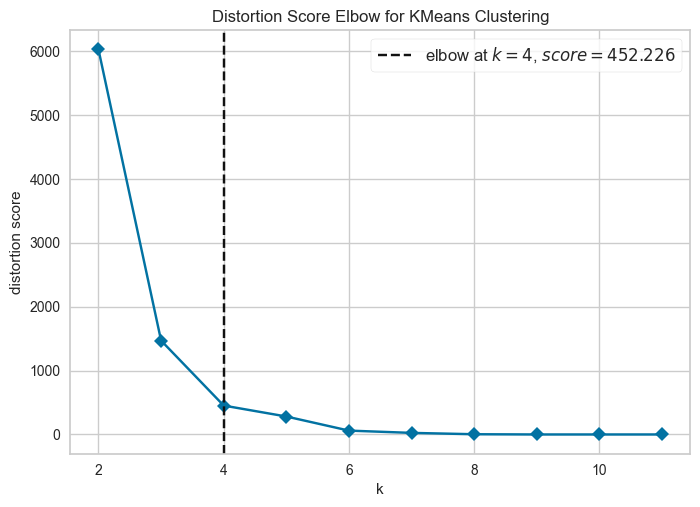

Optimal number of clusters according to the Elbow method: 4
Best parameters: 5
Silhouette Score: 0.9972086461705619
Calinski-Harabasz Index: 363168.62588036235
Davies-Bouldin Index: 0.2978945467744839
Dunn Index: 0.442622950819672
Clustering quality does not meet the thresholds.


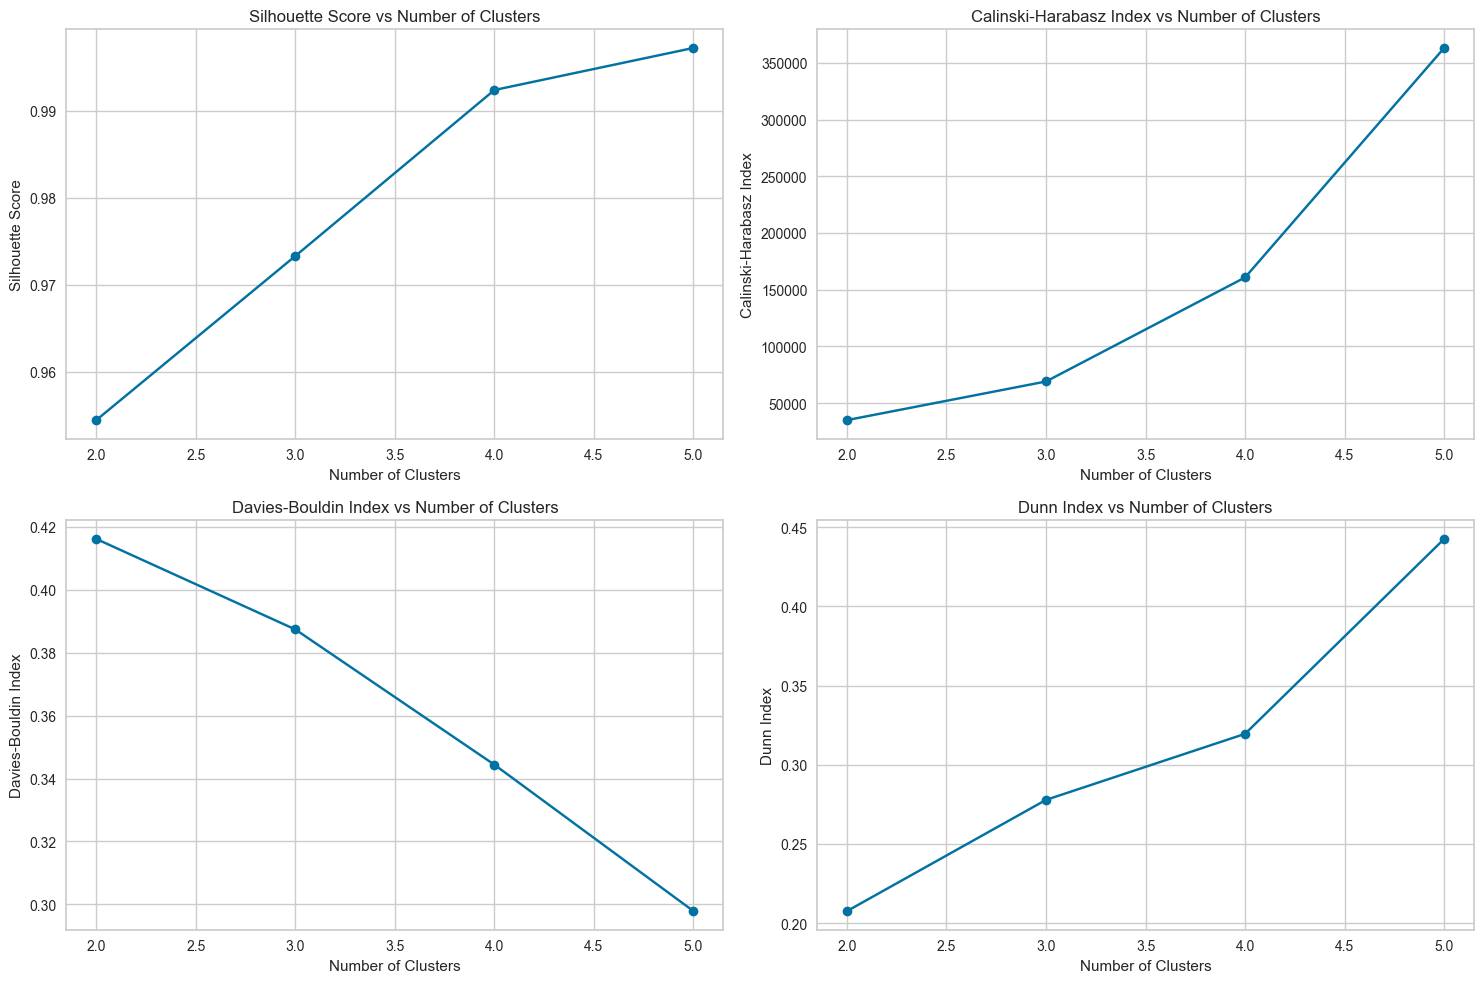

{'dashboard_title': 'Customer Analysis Dashboard', 'rows': [{'row_type': 'cards', 'items': [{'title': 'Total Customers', 'col_name': 'customer_id', 'function': 'count', 'value': 15000, 'cluster_values': {0: 13323, 1: 1279, 2: 103, 3: 268, 4: 27}}, {'title': 'Average Basket Count', 'col_name': 'basket_count', 'function': 'avg', 'value': 2.15, 'cluster_values': {0: 2.0, 1: 3.0, 2: 5.26, 3: 4.0, 4: 7.74}}, {'title': 'Total Products Purchased', 'col_name': 'product_id', 'function': 'count', 'value': 15000, 'cluster_values': {0: 13323, 1: 1279, 2: 103, 3: 268, 4: 27}}]}, {'row_type': 'charts', 'charts': [{'title': 'Basket Count Distribution', 'type': 'bar', 'x_axis_column': 'basket_count', 'y_axis_column': 'customer_id', 'series': [{'data': [42366585, 35956841, 26139578, 3262253, 20056678, 32037116, 17565651, 42079380, 25533477, 10385144, 5216868, 9036689, 20265792, 34654104, 31159555, 31733002, 44025439, 1920107, 13374538, 12434467, 25371082, 2068361, 28204561, 44417560, 29215183, 11360880

In [24]:
dataset = read_csv_auto('../../frontend/public/datasets/basket_details.csv')
process_dataset(dataset, ['product_id', 'basket_count'])